## 《Simple and Effective Text Matching with Richer Alignment Features》


### 论文主题：文本匹配
### 授课老师：himon

## 1. 前言
### 1.1 上节课内容回顾

模型结构：

<div>
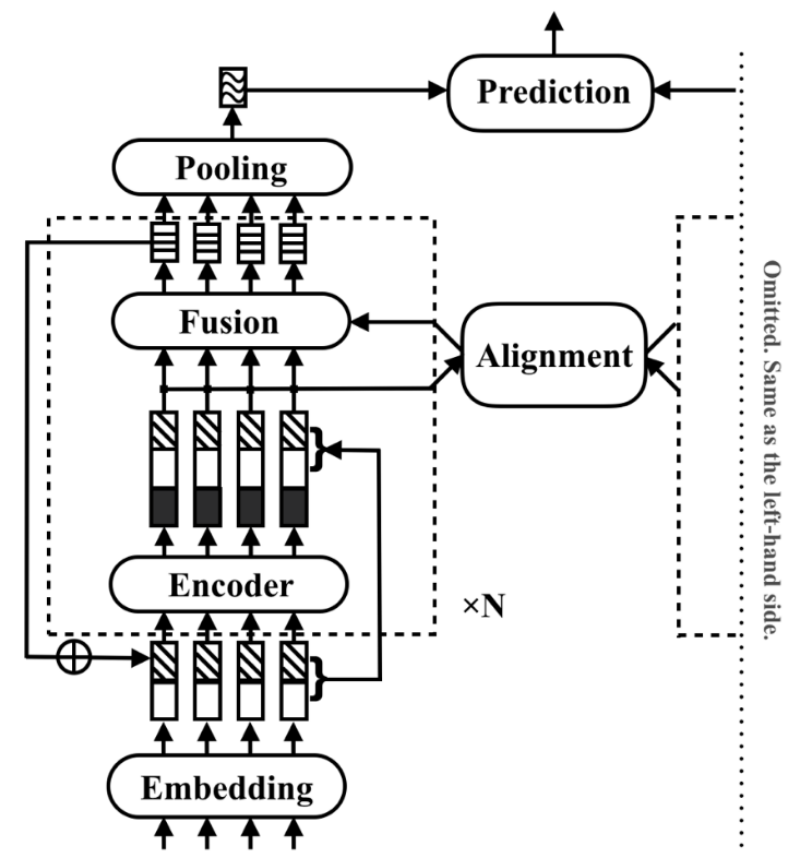
</div>

---

主要知识点：

<div>
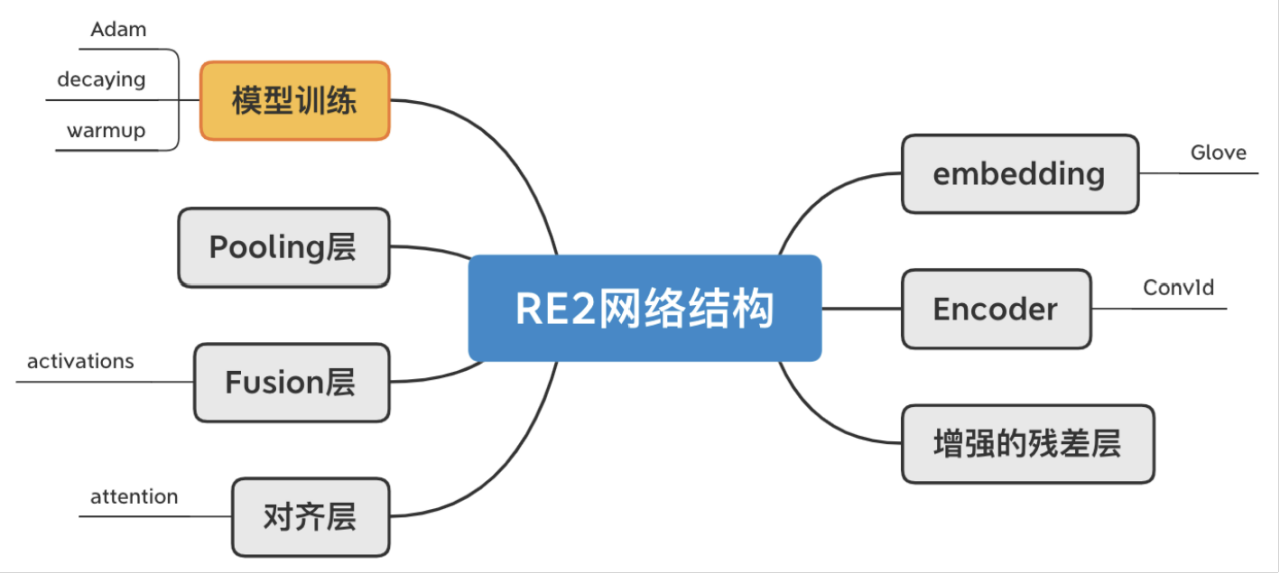
</div>

1. **RE2模型各层实现细节，Conv1d，Residual，attention ，Pooling ，Fusion Layer，Prediction Layer**
2. **模型训练细节/技巧，Adam，learning_rate decay，warmup**
3. **实验结果分析，数据讲解，评价指标介绍，四个数据集上实验结果，消融实验，鲁棒性测试，咬合敏感性分析，Case study**

### 1.2 本课知识树


#### 本课目标：

1. 熟悉模型训练的常规设计模式
2. 代码实现你就自己的模型网络
3. 训练你的模型
4. 先学会暂时摆脱 hive-level API



<table align='left'>
<tr>
<td><img src='p1.png' width='300' height='300'/></td>
<td><img src='k.png' width='800' height='1000'/></td>
</tr>
</table>

---


## 2. 准备工作
### 2.1 项目环境配置
- Python3.7
- jupyter notebook


项目依赖：

- torch (1.7.0+cpu)
- torchvision (0.8.1)
- tqdm (4.51.0)
- nltk (3.5)
- numpy (1.19.2)
- scikit-learn (0.23.2)
- msgpack-python (0.5.6)
- tensorboardX (2.1)
- json5 (0.9.5)

###  2.2 数据集下载

Quora DataSet:  https://drive.google.com/file/d/0B0PlTAo--BnaQWlsZl9FZ3l1c28/view?usp=sharing

## 3. 初识数据
### 3.1 QPP数据集

In [20]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

print('# File sizes')
for f in os.listdir('../data/orig/QPP'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('../data/orig/QPP/' + f) / 1000000, 2)) + 'MB')

# File sizes
train.tsv                     51.82MB
dev.tsv                       1.32MB
test.tsv                      1.32MB
wordvec.txt                   275.48MB
readme.txt                    0.0MB


In [7]:
import pandas as pd
df_dev = pd.read_csv('../data/QPP/orig/dev.tsv', sep='\t', names=['is_duplicate', 's1', 's2','id'])
df_dev.head()

,is_duplicate,s1,s2,id
0,1,How do I get funding for my web based startup ...,How do I get seed funding pre product ?,327970
1,0,Is honey a viable alternative to sugar for dia...,How would you compare the United States ' euth...,90348
2,1,How can I stop my depression ?,What can I do to stop being depressed ?,339556
3,0,Why is Mia Khalifa suddenly so popular ?,What are some tricks male porn stars have to l...,399933
4,1,How do you cook chicken gizzards ? What are th...,What can I do with chicken gizzards ?,185728


In [11]:
df_train = pd.read_csv('../data/QPP/orig/train.tsv', sep='\t',names=['is_duplicate', 's1', 's2','id'])
df_test = pd.read_csv('../data/QPP/orig/test.tsv', sep='\t',names=['is_duplicate', 's1', 's2','id'])
df_test.shape

(10000, 4)

In [12]:
df_train.shape

(384348, 4)

### 3.2 加载词向量

In [40]:
import numpy as np

def loadGloveModel(File):
    print("Loading Glove Model...")
    gloveModel = {}
    f = open(File,'r')
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([value for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    return gloveModel

gloveModel = loadGloveModel('../data/orig/QPP/wordvec.txt')
print(len(gloveModel)," words loaded!")
print("'hello's vocter:")
print(gloveModel['hello'])

Loading Glove Model...
106656  words loaded!
'hello's vocter:
['0.25233' '0.10176' '-0.67485' '0.21117' '0.43492' '0.16542' '0.48261'
 '-0.81222' '0.041321' '0.78502' '-0.077857' '-0.66324' '0.1464'
 '-0.29289' '-0.25488' '0.019293' '-0.20265' '0.98232' '0.028312'
 '-0.081276' '-0.1214' '0.13126' '-0.17648' '0.13556' '-0.16361'
 '-0.22574' '0.055006' '-0.20308' '0.20718' '0.095785' '0.22481' '0.21537'
 '-0.32982' '-0.12241' '-0.40031' '-0.079381' '-0.19958' '-0.015083'
 '-0.079139' '-0.18132' '0.20681' '-0.36196' '-0.30744' '-0.24422'
 '-0.23113' '0.09798' '0.1463' '-0.062738' '0.42934' '-0.078038'
 '-0.19627' '0.65093' '-0.22807' '-0.30308' '-0.12483' '-0.17568'
 '-0.14651' '0.15361' '-0.29518' '0.15099' '-0.51726' '-0.033564'
 '-0.23109' '-0.7833' '0.018029' '-0.15719' '0.02293' '0.49639' '0.029225'
 '0.05669' '0.14616' '-0.19195' '0.16244' '0.23898' '0.36431' '0.45263'
 '0.2456' '0.23803' '0.31399' '0.3487' '-0.035791' '0.56108' '-0.25345'
 '0.051964' '-0.10618' '-0.30962' '1.0585' 

### 3.3 文本分析
1. 分析s1+s2的序列长度分布

mean-train 62.03 std-train 33.55 mean-test 60.56 std-test 31.90 max-train 1226.00 max-test 756.00


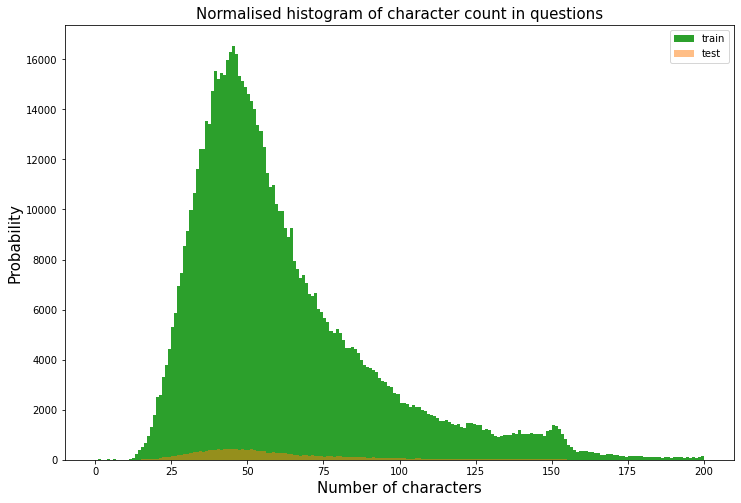

In [36]:
train_qs = pd.Series(df_train['s1'].tolist() + df_train['s2'].tolist()).astype(str)
test_qs = pd.Series(df_test['s1'].tolist() + df_test['s2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(12, 8))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], stacked=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], stacked=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

## 4.项目代码结构
### 4.1 代码结构设计图

<div>
<img src='step.png' width='300' height='400'/>
</div>



1. 数据加载和构建
2. 模型构建和初始化
3. 模型训练和评估
4. 模型保存和log持久化


### 4.2 模块实现细节



#### 4.2.1 数据加载和构建


<div>
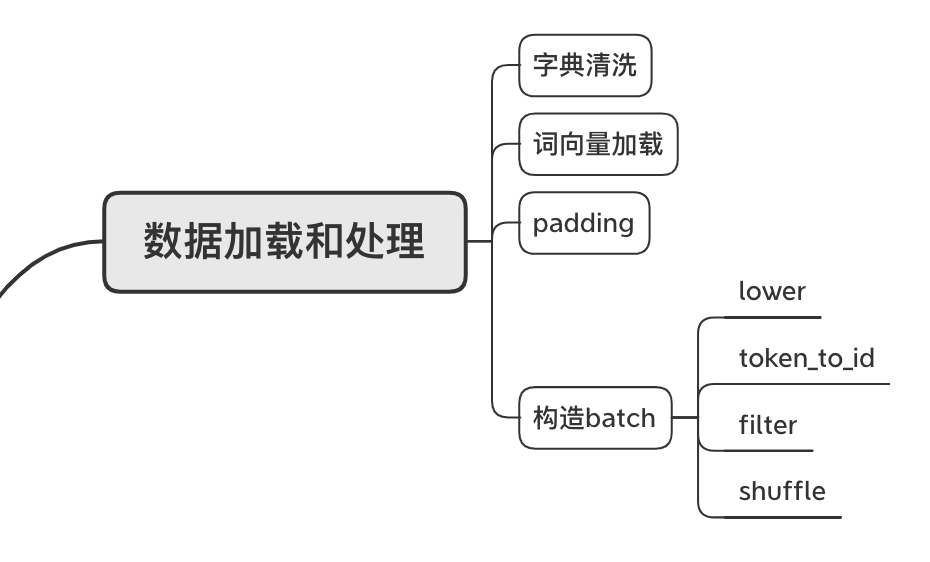
</div>

- 知识点：  
    1. 字典清洗，
    2. 词向量加载 
    3. padding 
    4. 构造batch：lower 
    5. 构造batch：filter 
    6. 构造batch：shuffle 

4.2.2 模型构建和初始化
<!-- 
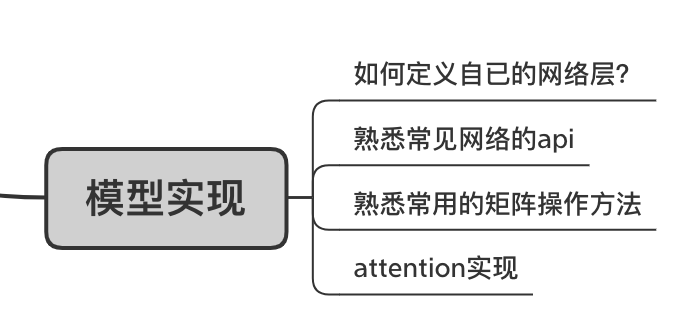
 -->

<div>
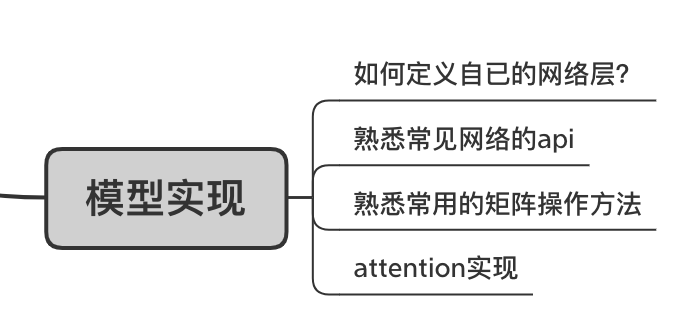
</div>


- 知识点  
    1. 自定义网络层实现 (三步走)
    2. 熟悉Pytorch中常见网络层的实现：Embedding，Dropout，Conv1d，Linear，GeLU，Pooling，Prediction，Residual

    3. 实现Pytorch常用的矩阵操作方法： transpose，masked_fill_，matmul，softmax，cat，值类型转换(float,bool), slice，unsqueeze，torch.ne，

4.2.3 模型训练和评估


<div>
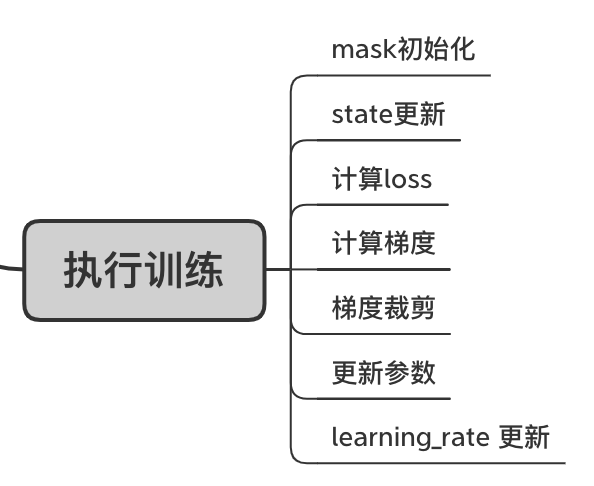
</div>


- 知识点  
    1. mask作用和实现方式
    2. 计算loss
    3. 计算梯度
    4. 梯度裁剪
    5. 更新参数
    6. learning_rate 更新
    7. 关闭梯度自动更新
    

4.2.4 模型保存和log持久化

<div>
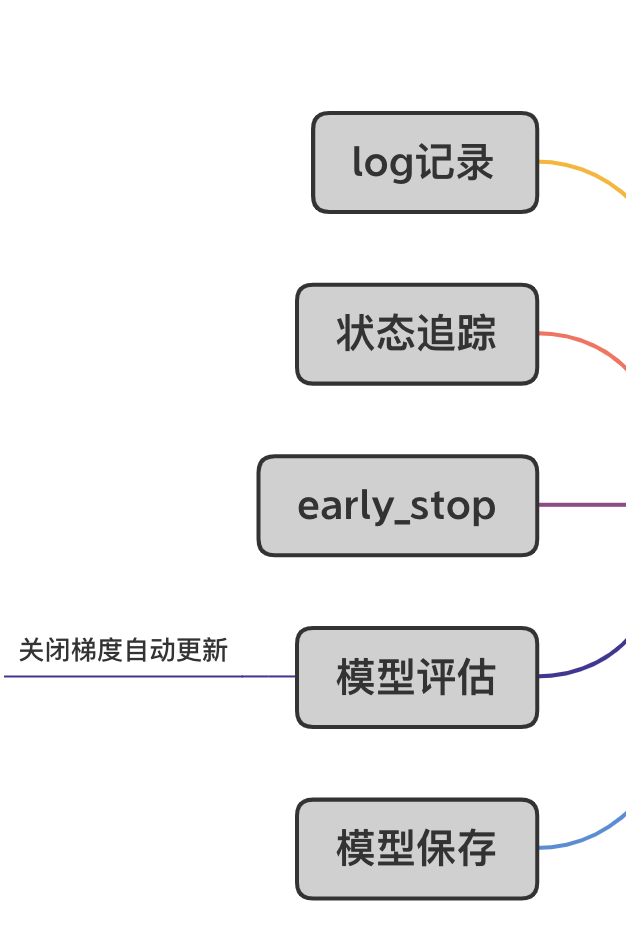
</div>


- 知识点  
    1. 关闭梯度自动更新
    2. early_stop作用和实现  
        1.训练步数达到固定步数 2. loss大于某个值  3. learning_rate小于某个值
    3. log记录，tensorboard使用
    4. 保存模型，state_dict含义
    
<div>
<img src="https://pic1.zhimg.com/80/v2-688947d4b4f9829752c69dcaa5a7c0a0_1440w.png" width="300"/>
</div>

In [8]:
# Define model
# 查看 state_dict

import torch.nn as nn
import torch
class TheModelClass(nn.Module):
    def __init__(self):
        super(TheModelClass, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
model = TheModelClass()

# Initialize optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print()
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]


## 5. 代码梳理及细节回顾

（pycharm）


## 6.课后做业

- 【代码实践】完整复现Network。 思想->作用->公式->代码实现，称作一个完整流程。
- 【思考题】 思考如何改进这个模型？并代码实现
- 【总结】 完成一篇博客，记下完整的学习过程、知识点以及自己的思考。